# **Implementation - Find Cointegrated Periods**

In [ ]:
# Searches historical periods with adequate cointegration for pairs trading
# IMPROVED VERSION: Merges intersecting periods

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import coint
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

class CointegrationTester:
    """Tests cointegration between pairs of assets"""

    def __init__(self, significance_level: float = 0.05):
        self.significance_level = significance_level

    def test_cointegration(self, series1: pd.Series, series2: pd.Series) -> Dict:
        """
        Performs Engle-Granger cointegration test

        Args:
            series1, series2: Price series (or log-prices)

        Returns:
            Dictionary with test results
        """
        # Cointegration test
        score, pvalue, _ = coint(series1, series2)

        # Calculate initial hedge ratio via OLS
        correlation = np.corrcoef(series1, series2)[0, 1]
        hedge_ratio = np.polyfit(series2, series1, 1)[0]

        # Results
        is_cointegrated = pvalue < self.significance_level

        results = {
            'score': score,
            'pvalue': pvalue,
            'is_cointegrated': is_cointegrated,
            'hedge_ratio_static': hedge_ratio,
            'correlation': correlation,
            'significance_level': self.significance_level
        }

        return results

class CointegrationScanner:
    """Scanner to find ideal cointegration periods"""

    def __init__(self, tickers: List[str], significance_level: float = 0.05):
        self.tickers = tickers
        self.tester = CointegrationTester(significance_level)
        self.data = None

    def download_data(self, start_date: str = '2020-01-01', end_date: str = None):
        """Downloads historical data - CORRECTED VERSION"""

        print("COLLECTING HISTORICAL DATA...")
        print("=" * 50)

        try:
            # Download both tickers at once
            tickers_str = ' '.join(self.tickers)
            raw_data = yf.download(tickers_str, start=start_date, end=end_date, progress=False)

            if raw_data.empty:
                print("❌ No data downloaded")
                return None

            # Extract Close prices
            if 'Close' in raw_data.columns:
                if len(self.tickers) == 1:
                    # Only one ticker
                    self.data = pd.DataFrame({self.tickers[0]: raw_data['Close']})
                else:
                    # Multiple tickers
                    self.data = raw_data['Close'].copy()
            else:
                print("❌ Unexpected data structure")
                return None

            self.data = self.data.dropna()

            if self.data.empty:
                print("❌ Empty data after cleaning")
                return None

            print(f"✓ Data collected: {len(self.data)} records")
            print(f"✓ Period: {self.data.index[0].date()} to {self.data.index[-1].date()}")
            print(f"✓ Columns: {list(self.data.columns)}")

            return self.data

        except Exception as e:
            print(f"❌ Download error: {e}")
            return None

    def scan_rolling_periods(
            self,
            window_sizes: List[int] = [90, 180, 252, 360, 504],
            step_size: int = 30,
            use_log_prices: bool = True) -> List[Dict]:
        """
        Scans historical periods in rolling windows searching for cointegration

        Args:
            window_sizes: List of window sizes (in days)
            step_size: Step between windows (in days)
            use_log_prices: If True, uses log-prices

        Returns:
            List of periods with adequate cointegration (AFTER MERGE)
        """

        if self.data is None:
            raise ValueError("Execute download_data() first")

        print("SCANNING COINTEGRATION PERIODS...")
        print("=" * 60)

        # Prepare data
        asset1, asset2 = self.tickers[0], self.tickers[1]
        prices1 = self.data[asset1]
        prices2 = self.data[asset2]

        if use_log_prices:
            prices1 = np.log(prices1)
            prices2 = np.log(prices2)
            print("📊 Using log-prices for analysis")

        cointegrated_periods = []

        # Test different window sizes
        for window_size in window_sizes:
            print(f"\n📈 Testing window of {window_size} days...")
            window_results = []

            # Rolling windows
            for i in range(0, len(self.data) - window_size, step_size):
                end_idx = i + window_size

                # Extract window
                window_prices1 = prices1.iloc[i:end_idx]
                window_prices2 = prices2.iloc[i:end_idx]

                start_date = window_prices1.index[0]
                end_date = window_prices1.index[-1]

                # Cointegration test
                try:
                    results = self.tester.test_cointegration(window_prices1, window_prices2)

                    if results['is_cointegrated']:
                        period_info = {
                            'window_size': window_size,
                            'start_date': start_date,
                            'end_date': end_date,
                            'duration_days': (end_date - start_date).days,
                            'pvalue': results['pvalue'],
                            'correlation': results['correlation'],
                            'hedge_ratio': results['hedge_ratio_static'],
                            'score': results['score'],
                            'quality_score': self._calculate_quality_score(results)
                        }

                        cointegrated_periods.append(period_info)
                        window_results.append(period_info)

                except Exception as e:
                    continue  # Skip problematic windows

            print(f" ✓ Found {len(window_results)} cointegrated periods (before merge)")

        # ==========================================
        # NEW: MERGE OF INTERSECTING PERIODS
        # ==========================================
        print(f"\n🔄 PROCESSING MERGES OF INTERSECTING PERIODS...")
        print("=" * 60)

        merged_periods = self._merge_overlapping_periods(cointegrated_periods)

        print(f"✅ Periods after merge: {len(merged_periods)} (reduced from {len(cointegrated_periods)})")

        # Sort by quality
        merged_periods.sort(key=lambda x: x['quality_score'], reverse=True)

        print(f"\n✅ SCAN COMPLETE:")
        print(f" Total cointegrated periods found: {len(merged_periods)}")

        return merged_periods

    def _merge_overlapping_periods(self, periods: List[Dict]) -> List[Dict]:
        """
        Merges overlapping periods into a larger period

        Args:
            periods: List of original periods

        Returns:
            List of periods after intersection merge
        """

        if not periods:
            return []

        # Sort by start date
        sorted_periods = sorted(periods, key=lambda x: x['start_date'])

        merged = []
        current_group = [sorted_periods[0]]

        for i in range(1, len(sorted_periods)):
            period = sorted_periods[i]
            last_period = current_group[-1]

            # Check for intersection
            if self._periods_overlap(last_period, period):
                # Add to current group
                current_group.append(period)
                print(f"  🔗 Intersection found: {last_period['start_date'].date()} - {last_period['end_date'].date()} "
                      f"∩ {period['start_date'].date()} - {period['end_date'].date()}")
            else:
                # No intersection - merge previous group and start new one
                merged_period = self._create_merged_period(current_group)
                merged.append(merged_period)
                current_group = [period]

        # Don't forget the last group
        merged_period = self._create_merged_period(current_group)
        merged.append(merged_period)

        # Reduction log
        print(f"\n📊 Reduction: {len(periods)} periods → {len(merged)} merged periods")

        return merged

    def _periods_overlap(self, period1: Dict, period2: Dict) -> bool:
        """
        Checks if two periods overlap

        Args:
            period1, period2: Dictionaries with 'start_date' and 'end_date'

        Returns:
            True if there is an intersection
        """

        # Period 1: [start1, end1]
        # Period 2: [start2, end2]

        # If period2 starts BEFORE period1 ends AND
        # If period1 starts BEFORE period2 ends
        # → there is an intersection

        return (period2['start_date'] <= period1['end_date'] and
                period1['start_date'] <= period2['end_date'])

    def _create_merged_period(self, period_group: List[Dict]) -> Dict:
        """
        Creates a merged period from a group of intersecting periods

        Args:
            period_group: List of intersecting periods

        Returns:
            Dictionary with merged period (using extreme dates and average metrics)
        """

        if len(period_group) == 1:
            # Only one period, return as is
            return period_group[0]

        # Start date is the OLDEST
        start_date = min([p['start_date'] for p in period_group])

        # End date is the MOST RECENT
        end_date = max([p['end_date'] for p in period_group])

        # Durations in days
        duration = (end_date - start_date).days

        # Average metrics
        avg_pvalue = np.mean([p['pvalue'] for p in period_group])
        avg_correlation = np.mean([p['correlation'] for p in period_group])
        avg_hedge_ratio = np.mean([p['hedge_ratio'] for p in period_group])
        avg_quality = np.mean([p['quality_score'] for p in period_group])
        avg_window = np.mean([p['window_size'] for p in period_group])

        # Best score (minimum p-value)
        best_score = min([p['score'] for p in period_group])

        # Windows that compose this merged period
        window_composition = [p['window_size'] for p in period_group]

        merged_period = {
            'window_size': int(avg_window),  # Average size
            'start_date': start_date,
            'end_date': end_date,
            'duration_days': duration,
            'pvalue': avg_pvalue,
            'correlation': avg_correlation,
            'hedge_ratio': avg_hedge_ratio,
            'score': best_score,
            'quality_score': avg_quality,
            'num_periods_merged': len(period_group),
            'window_composition': window_composition,
            'is_merged': len(period_group) > 1
        }

        return merged_period

    def _calculate_quality_score(self, results: Dict) -> float:
        """
        Calculates cointegration quality score

        Combines low p-value, high correlation, and other factors
        """

        pvalue_score = max(0, 1 - results['pvalue'] / 0.05)  # Better when p-value < 0.05
        correlation_score = abs(results['correlation'])  # Better when |corr| is high

        # Combined score (0 to 1)
        quality_score = (pvalue_score * 0.6) + (correlation_score * 0.4)

        return quality_score

    def get_best_periods(self, top_n: int = 10) -> List[Dict]:
        """Returns the N best periods"""
        periods = self.scan_rolling_periods()
        return periods[:top_n]

    def analyze_period_stability(self, periods: List[Dict]) -> Dict:
        """Analyzes the stability of the found periods"""

        if not periods:
            return {"message": "No cointegrated periods found"}

        analysis = {
            'total_periods': len(periods),
            'total_merged': sum(1 for p in periods if p.get('is_merged', False)),
            'avg_pvalue': np.mean([p['pvalue'] for p in periods]),
            'avg_correlation': np.mean([p['correlation'] for p in periods]),
            'avg_duration': np.mean([p['duration_days'] for p in periods]),
            'window_distribution': {},
            'merge_stats': {
                'total_original': sum([p.get('num_periods_merged', 1) for p in periods]),
                'reduction_ratio': f"{(1 - len(periods) / sum([p.get('num_periods_merged', 1) for p in periods])) * 100:.1f}%"
            }
        }

        # Distribution by window size
        for period in periods:
            window = period['window_size']
            if window not in analysis['window_distribution']:
                analysis['window_distribution'][window] = 0
            analysis['window_distribution'][window] += 1

        return analysis

    def print_best_periods(self, top_n: int = 5):
        """Displays the best periods found"""

        periods = self.get_best_periods(top_n)

        print(f"\n🏆 TOP {top_n} BEST COINTEGRATION PERIODS:")
        print("=" * 100)

        if not periods:
            print("❌ No period with adequate cointegration found")
            print("\nSuggestions:")
            print("- Try different historical periods")
            print("- Relax the significance level (e.g., 0.10)")
            print("- Test other asset pairs")
            return

        for i, period in enumerate(periods, 1):
            merge_info = f" [MERGED: {period['num_periods_merged']} periods]" if period.get('is_merged', False) else ""

            print(f"\n#{i} - Window of {period['window_size']} days{merge_info}")
            print(f" 📅 Period: {period['start_date'].date()} to {period['end_date'].date()}")
            print(f" 📊 P-value: {period['pvalue']:.4f}")
            print(f" 🔗 Correlation: {period['correlation']:+.4f}")
            print(f" ⚖️ Hedge Ratio: {period['hedge_ratio']:.4f}")
            print(f" 🏅 Quality Score: {period['quality_score']:.3f}")

        # Stability analysis
        analysis = self.analyze_period_stability(periods)

        print(f"\n📈 STABILITY ANALYSIS:")
        print(f" Average P-value: {analysis['avg_pvalue']:.4f}")
        print(f" Average Correlation: {analysis['avg_correlation']:+.4f}")
        print(f" Average Duration: {analysis['avg_duration']:.0f} days")
        print(f" Merged Periods: {analysis['total_merged']} / {analysis['total_periods']}")
        print(f" Duplication Reduction: {analysis['merge_stats']['reduction_ratio']}")

        print(f"\n📊 DISTRIBUTION BY WINDOW:")
        for window, count in sorted(analysis['window_distribution'].items()):
            print(f" {window} days: {count} periods")

    def export_periods_to_csv(self, filename: str = None):
        """Exports periods to CSV"""

        periods = self.scan_rolling_periods()

        if not periods:
            print("❌ No periods to export")
            return

        if filename is None:
            filename = f"cointegration_periods_{self.tickers[0]}_{self.tickers[1]}.csv"

        df = pd.DataFrame(periods)

        # Convert dates to string for better readability
        df['start_date'] = df['start_date'].dt.strftime('%Y-%m-%d')
        df['end_date'] = df['end_date'].dt.strftime('%Y-%m-%d')

        df.to_csv(filename, index=False)

        print(f"✅ Periods exported to: {filename}")
        print(f"   Total rows: {len(df)}")
        print(f"   Merged periods: {df['is_merged'].sum()} / {len(df)}")


# MAIN FUNCTION TO USE THE SCANNER

def find_cointegrated_periods(
                             asset1: str = 'BTC-USD',
                             asset2: str = 'ETH-USD',
                             start_date: str = '2020-01-01',
                             significance_level: float = 0.05):
    """
    Main function to find cointegration periods (WITH MERGE)

    Usage:
        find_cointegrated_periods('BTC-USD', 'ETH-USD', '2020-01-01')
    """

    print("CRYPTUM COINTEGRATION SCANNER - MERGED VERSION")
    print("=" * 60)
    print(f"🔍 Searching for cointegration periods between {asset1} and {asset2}")
    print(f"📅 From: {start_date}")
    print(f"📊 Significance level: {significance_level}")

    # Create scanner
    scanner = CointegrationScanner([asset1, asset2], significance_level)

    # Download data
    scanner.download_data(start_date)

    # Find and display best periods
    scanner.print_best_periods(10)

    # Export results
    scanner.export_periods_to_csv()

    return scanner


if __name__ == "__main__":
    # Main example: BTC vs ETH WITH MERGE
    print("EXECUTING COINTEGRATION SCANNER (WITH MERGE)...")

    scanner = find_cointegrated_periods('BTC-USD', 'ETH-USD', '2018-01-01')

    print("\n" + "="*60)
    print("SCANNER COMPLETE!")
    print("="*60)
    print("✅ Intersecting periods were automatically merged")
    print("📄 CSV file generated with unique periods (no duplication)")
    print("🎯 Use the merged periods for backtesting without redundancy")
    print("💡 'is_merged' column indicates if a period was a result of a merge")


EXECUTING COINTEGRATION SCANNER (WITH MERGE)...
CRYPTUM COINTEGRATION SCANNER - MERGED VERSION
🔍 Searching for cointegration periods between BTC-USD and ETH-USD
📅 From: 2018-01-01
📊 Significance level: 0.05
COLLECTING HISTORICAL DATA...
✓ Data collected: 2944 records
✓ Period: 2018-01-01 to 2026-01-22
✓ Columns: ['BTC-USD', 'ETH-USD']
SCANNING COINTEGRATION PERIODS...
📊 Using log-prices for analysis

📈 Testing window of 90 days...
 ✓ Found 8 cointegrated periods (before merge)

📈 Testing window of 180 days...
 ✓ Found 7 cointegrated periods (before merge)

📈 Testing window of 252 days...
 ✓ Found 5 cointegrated periods (before merge)

📈 Testing window of 360 days...
 ✓ Found 3 cointegrated periods (before merge)

📈 Testing window of 504 days...
 ✓ Found 3 cointegrated periods (before merge)

🔄 PROCESSING MERGES OF INTERSECTING PERIODS...
  🔗 Intersection found: 2018-06-30 - 2018-09-27 ∩ 2018-07-30 - 2018-10-27
  🔗 Intersection found: 2018-11-27 - 2019-02-24 ∩ 2018-12-27 - 2019-06-24
  

# **Backtesting the Strategy**

CRYPTUM ADAPTIVE PAIRS TRADING BACKTEST SYSTEM

📥 Loading periods from file: cointegration_periods_BTC-USD_ETH-USD.csv
✅ 6 periods found in CSV

📊 Periods converted for backtesting:
  1. Window 90d - Quality 0.86: 2020-05-20 to 2020-08-17
  2. Window 282d - Quality 0.80: 2021-04-15 to 2024-01-23
  3. Window 90d - Quality 0.74: 2018-06-30 to 2018-10-27
  4. Window 135d - Quality 0.67: 2018-11-27 to 2019-06-24
  5. Window 225d - Quality 0.59: 2024-08-27 to 2025-10-20
  ... and 1 more periods

🚀 EXECUTING BACKTESTING OVER 6 PERIODS

📥 Downloading data for Window 90d - Quality 0.86...

BACKTESTING: Window 90d - Quality 0.86
Period: 2020-05-20 to 2020-08-16
Days: 89
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $9,055.46
Total Return: -9.45%
Sharpe Ratio: -3.42
Max Drawdown: 10.16%

📈 TRADES:
Total: 4
Wins: 0 (0.0%)
Losses: 4
Average P&L: $-226.57

⚖️  vs BUY & HOLD BTC:
Strategy: -9.45%
Buy & Hold: +24.89%
Outperformance: -34.33%
❌ Buy & Hold performed better
✅ Plot saved: backtes

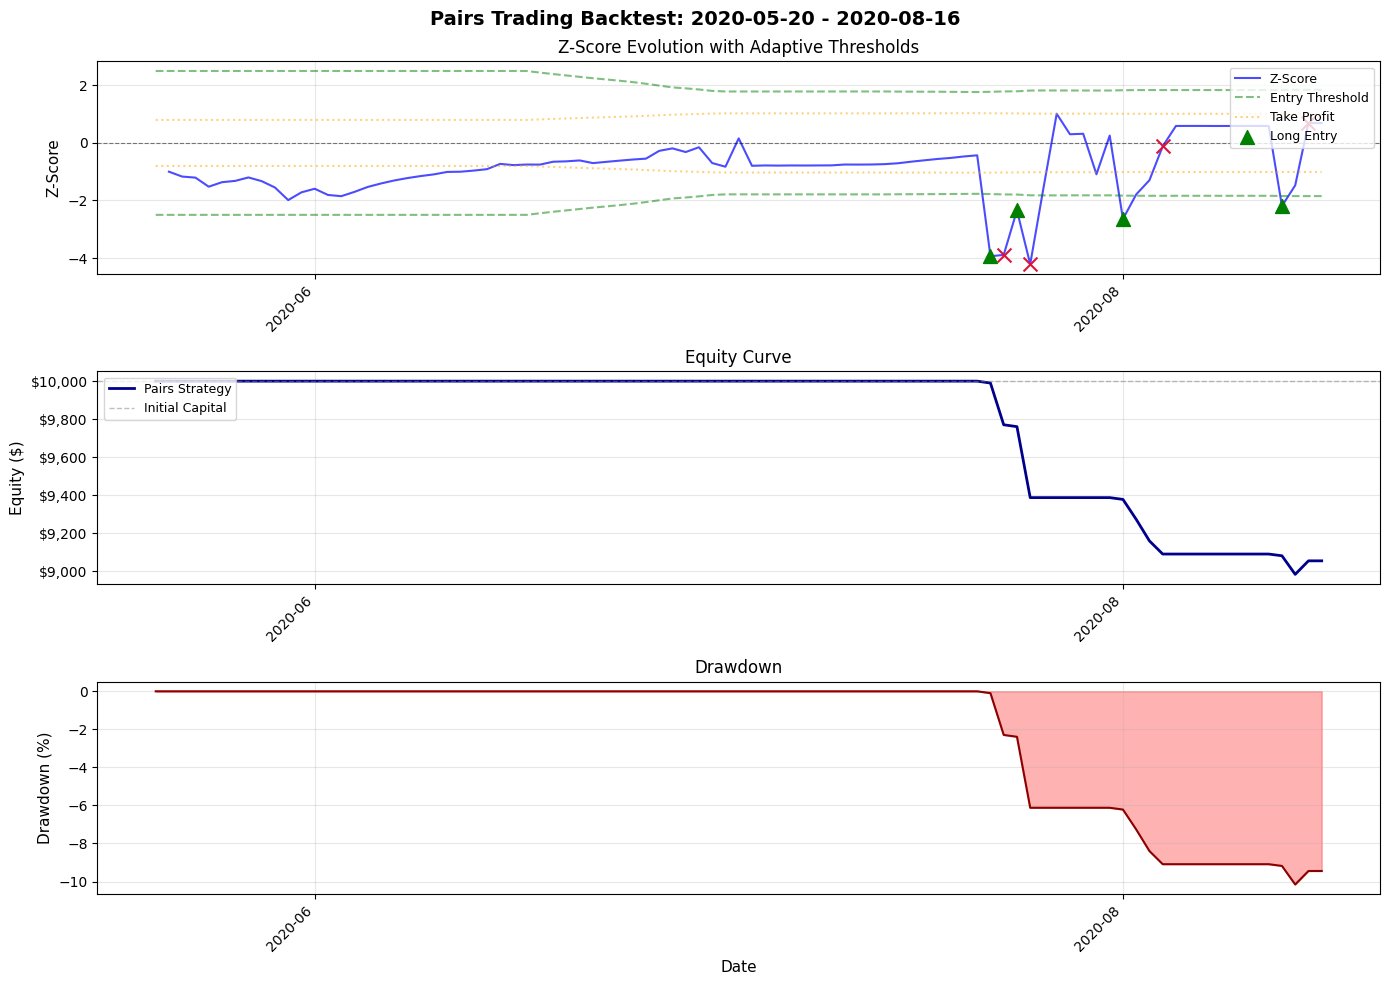


📥 Downloading data for Window 282d - Quality 0.80...

BACKTESTING: Window 282d - Quality 0.80
Period: 2021-04-15 to 2024-01-22
Days: 1013
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $7,747.80
Total Return: -22.52%
Sharpe Ratio: -1.09
Max Drawdown: 24.30%

📈 TRADES:
Total: 60
Wins: 22 (36.7%)
Losses: 38
Average P&L: $-28.85

⚖️  vs BUY & HOLD BTC:
Strategy: -22.52%
Buy & Hold: -37.60%
Outperformance: +15.08%
✅ Strategy outperformed Buy & Hold!
✅ Plot saved: backtest_2021-04-15_2024-01-23.png


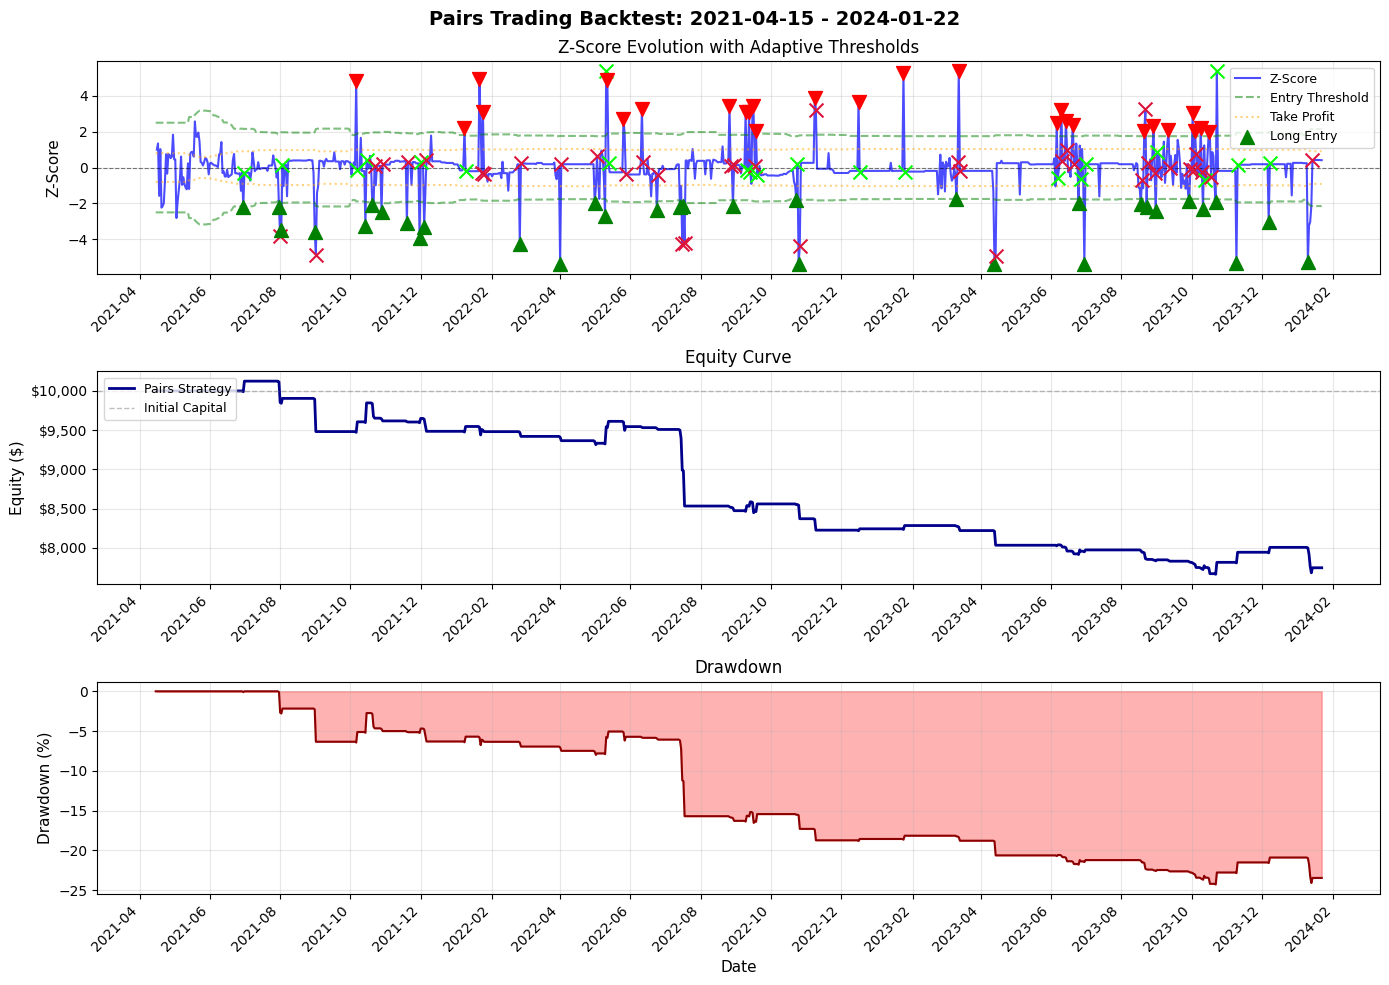


📥 Downloading data for Window 90d - Quality 0.74...

BACKTESTING: Window 90d - Quality 0.74
Period: 2018-06-30 to 2018-10-26
Days: 119
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $10,303.84
Total Return: +3.04%
Sharpe Ratio: 1.55
Max Drawdown: 1.35%

📈 TRADES:
Total: 5
Wins: 3 (60.0%)
Losses: 2
Average P&L: $70.80

⚖️  vs BUY & HOLD BTC:
Strategy: +3.04%
Buy & Hold: +1.10%
Outperformance: +1.93%
✅ Strategy outperformed Buy & Hold!
✅ Plot saved: backtest_2018-06-30_2018-10-27.png


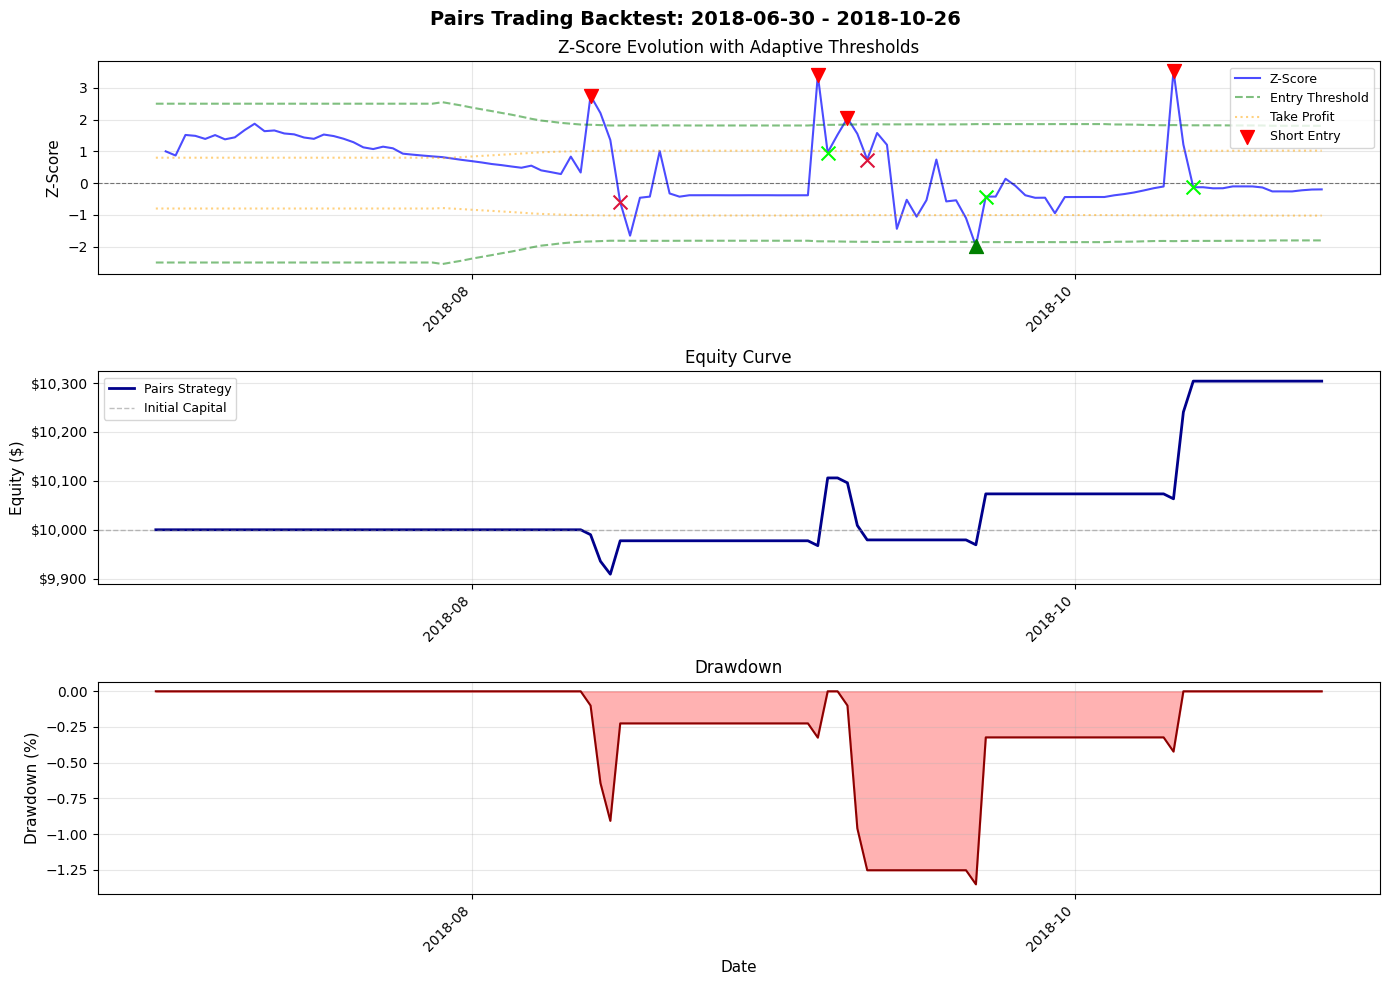


📥 Downloading data for Window 135d - Quality 0.67...

BACKTESTING: Window 135d - Quality 0.67
Period: 2018-11-27 to 2019-06-23
Days: 209
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $11,051.20
Total Return: +10.51%
Sharpe Ratio: 1.48
Max Drawdown: 3.25%

📈 TRADES:
Total: 9
Wins: 5 (55.6%)
Losses: 4
Average P&L: $126.74

⚖️  vs BUY & HOLD BTC:
Strategy: +10.51%
Buy & Hold: +184.12%
Outperformance: -173.61%
❌ Buy & Hold performed better
✅ Plot saved: backtest_2018-11-27_2019-06-24.png


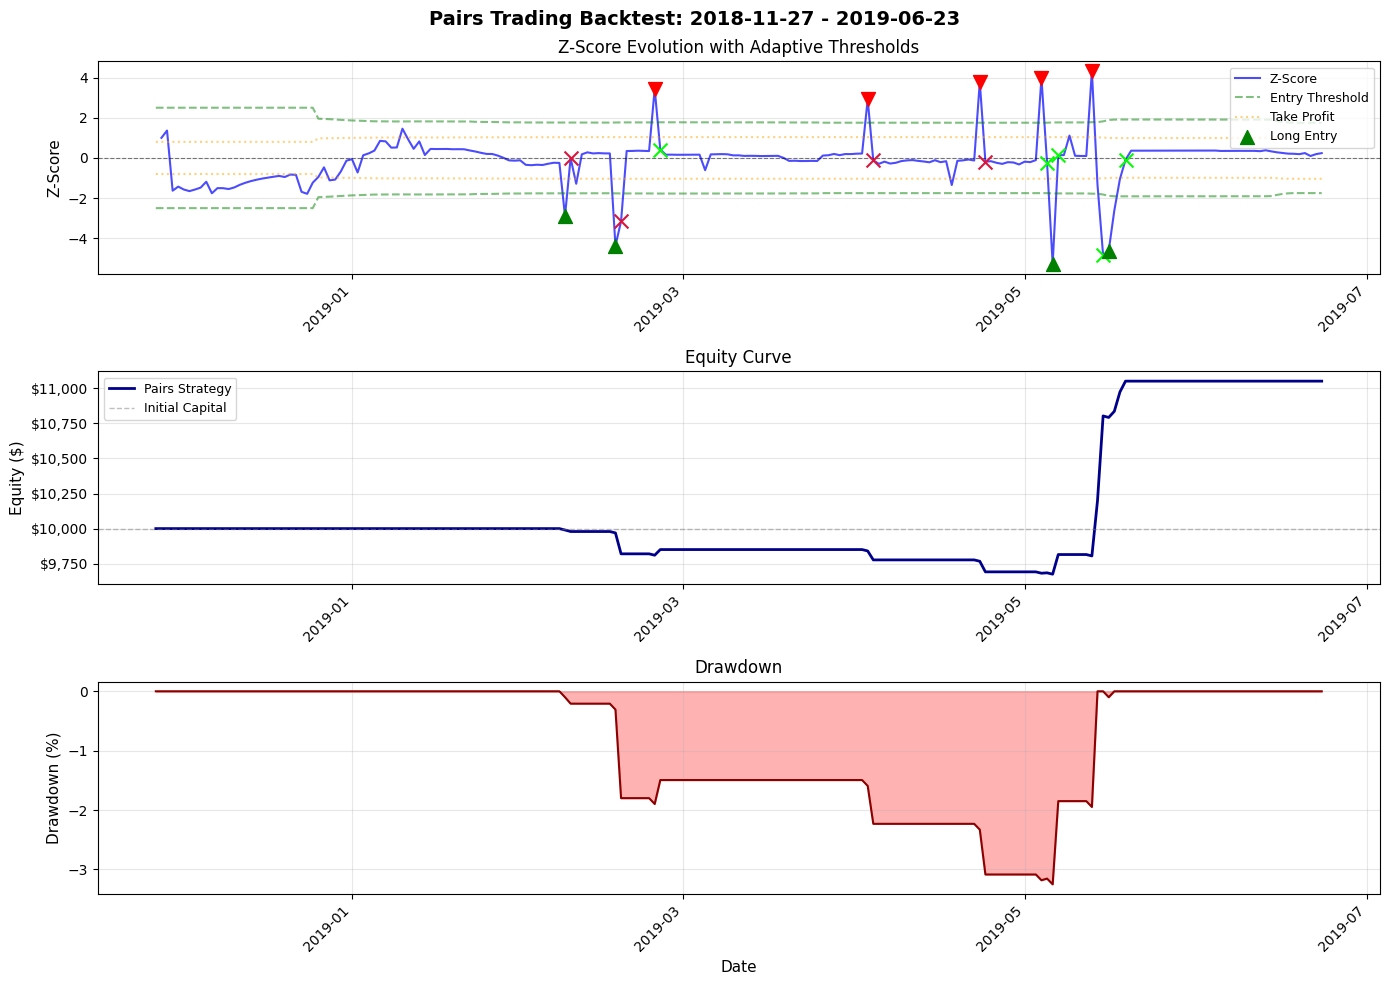


📥 Downloading data for Window 225d - Quality 0.59...

BACKTESTING: Window 225d - Quality 0.59
Period: 2024-08-27 to 2025-10-19
Days: 419
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $9,250.53
Total Return: -7.49%
Sharpe Ratio: -0.55
Max Drawdown: 11.70%

📈 TRADES:
Total: 16
Wins: 7 (43.8%)
Losses: 9
Average P&L: $-37.12

⚖️  vs BUY & HOLD BTC:
Strategy: -7.49%
Buy & Hold: +82.62%
Outperformance: -90.12%
❌ Buy & Hold performed better
✅ Plot saved: backtest_2024-08-27_2025-10-20.png


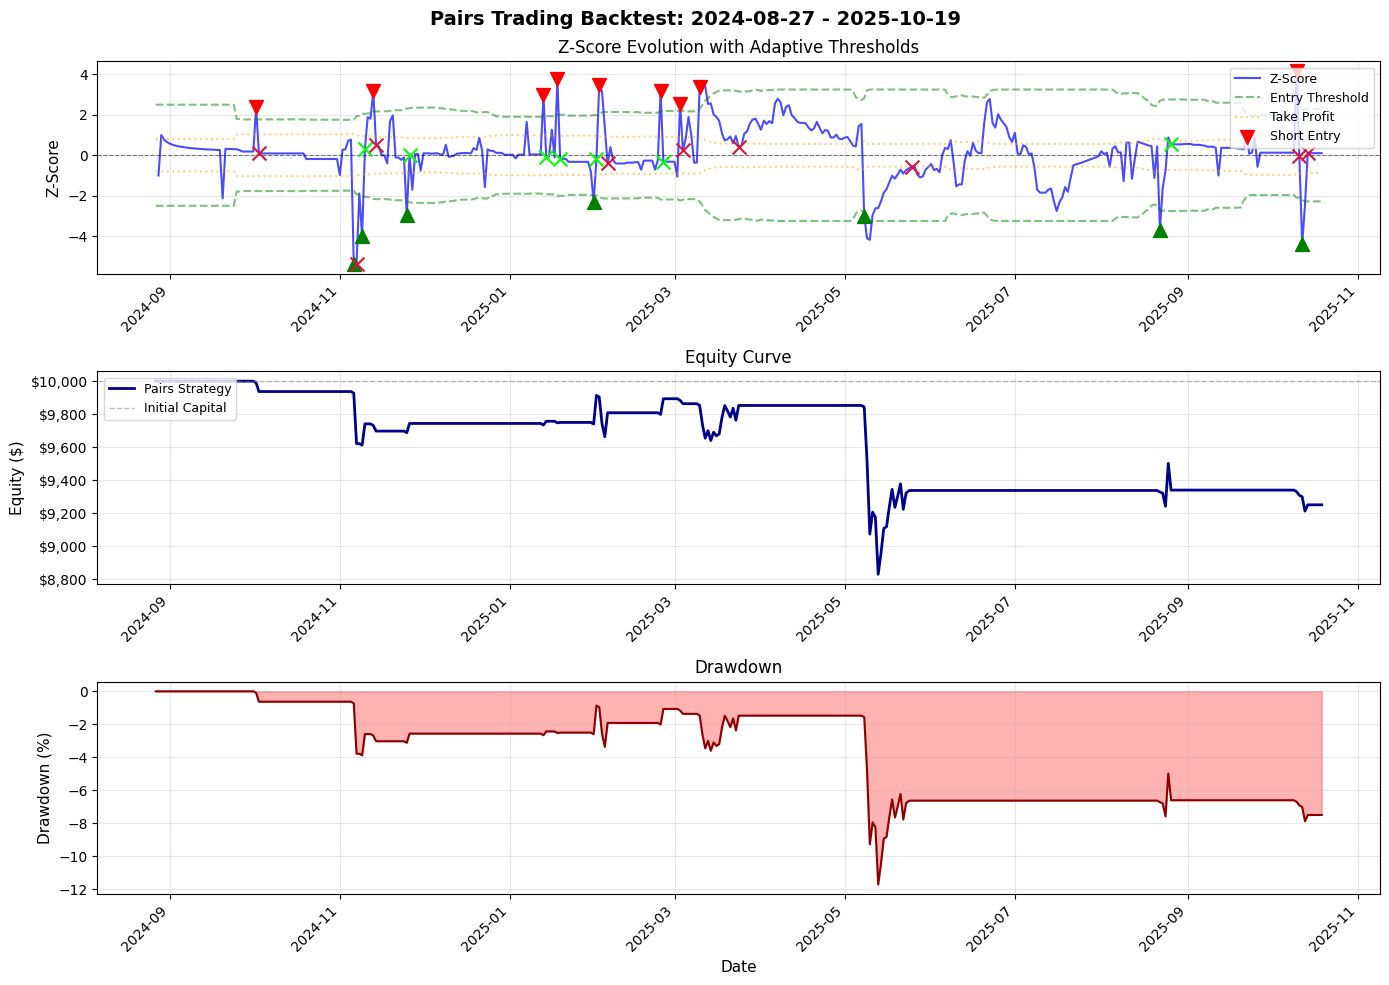


📥 Downloading data for Window 153d - Quality 0.57...

BACKTESTING: Window 153d - Quality 0.57
Period: 2023-10-02 to 2024-06-08
Days: 251
Initial Capital: $10,000.00

📊 RESULTS:
Final Capital: $10,062.26
Total Return: +0.62%
Sharpe Ratio: 0.14
Max Drawdown: 4.73%

📈 TRADES:
Total: 10
Wins: 6 (60.0%)
Losses: 4
Average P&L: $16.45

⚖️  vs BUY & HOLD BTC:
Strategy: +0.62%
Buy & Hold: +151.74%
Outperformance: -151.12%
❌ Buy & Hold performed better
✅ Plot saved: backtest_2023-10-02_2024-06-09.png


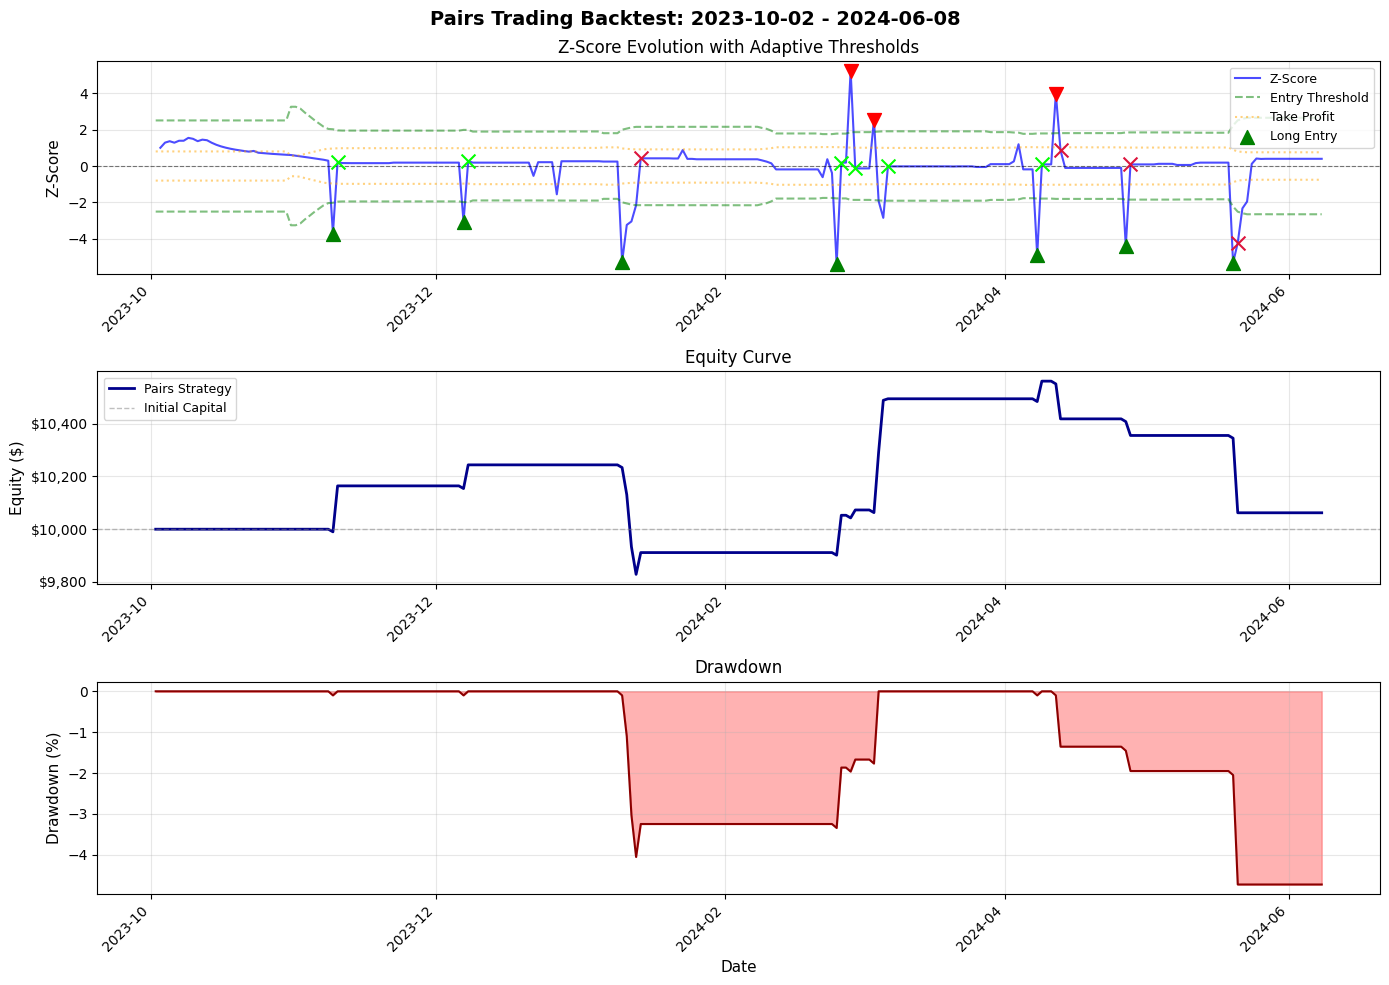


📊 CONSOLIDATED SUMMARY - ALL PERIODS

Period                    Return       Sharpe     MaxDD      Trades   WinRate    vs B&H
-----------------------------------------------------------------------------------------------
2020-05-20 - 2020-08-16        -9.45%    -3.42    10.16%      4      0.0% ❌
2021-04-15 - 2024-01-22       -22.52%    -1.09    24.30%     60     36.7% ✅
2018-06-30 - 2018-10-26        +3.04%     1.55     1.35%      5     60.0% ✅
2018-11-27 - 2019-06-23       +10.51%     1.48     3.25%      9     55.6% ❌
2024-08-27 - 2025-10-19        -7.49%    -0.55    11.70%     16     43.8% ❌
2023-10-02 - 2024-06-08        +0.62%     0.14     4.73%     10     60.0% ❌

AGGREGATED STATISTICS:
Average Return:           -4.21%
Average Sharpe:            -0.31
Average Max Drawdown:      9.25%
Total Trades:         104
Average Win Rate:          42.7%
Periods Outperformed:  2/6 (33%)

✅ Backtesting complete!
📁 6 plots saved


'\nINTEGRATION WITH THE COINTEGRATION SCANNER:\n=========================================\n\nTo integrate with the previous scanner, use:\n\nfrom cointegration_scanner import CointegrationScanner\n\n# 1. Find cointegration periods\nscanner = CointegrationScanner([\'BTC-USD\', \'ETH-USD\'])\nscanner.download_data(\'2020-01-01\')\nperiods_found = scanner.get_best_periods(10)\n\n# 2. Convert to periods format\nbacktest_periods = []\nfor period in periods_found:\n    backtest_periods.append({\n        \'start\': period[\'start_date\'].strftime(\'%Y-%m-%d\'),\n        \'end\': period[\'end_date\'].strftime(\'%Y-%m-%d\'),\n        \'name\': f"Window {period[\'window_size\']}d"\n    })\n\n# 3. Execute backtests\nexecutor = MultiPeriodBacktester(\'BTC-USD\', \'ETH-USD\', 10000)\nresults = executor.run_multiple_periods(backtest_periods)\n'

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DATA STRUCTURES
# =============================================================================

@dataclass
class Trade:
    """Structure to store trade information"""
    entry_date: datetime
    exit_date: datetime
    entry_price_btc: float
    entry_price_eth: float
    exit_price_btc: float
    exit_price_eth: float
    entry_zscore: float
    exit_zscore: float
    position_type: str  # 'LONG_SPREAD' or 'SHORT_SPREAD'
    quantity_btc: float
    quantity_eth: float
    pnl: float
    pnl_pct: float
    holding_days: int
    exit_reason: str  # 'TAKE_PROFIT', 'STOP_LOSS', 'END_OF_PERIOD'

@dataclass
class BacktestResult:
    """Structure for backtest results"""
    period_start: datetime
    period_end: datetime
    initial_capital: float
    final_capital: float
    total_return_pct: float
    sharpe_ratio: float
    max_drawdown: float
    total_trades: int
    winning_trades: int
    losing_trades: int
    win_rate: float
    avg_trade_pnl: float
    avg_winning_trade: float
    avg_losing_trade: float
    best_trade: float
    worst_trade: float
    total_days: int
    trading_days: int
    exposure_pct: float

    # Buy & Hold comparison
    bh_return_pct: float
    bh_max_drawdown: float
    outperformance: float

# =============================================================================
# ADAPTIVE KALMAN FILTER
# =============================================================================

class AdaptiveKalmanFilter:
    """
    Kalman filter with adaptive parameters for dynamic hedge ratio
    Adjusts entry/exit thresholds based on spread volatility
    """

    def __init__(self,
                 delta: float = 1e-4,
                 Ve: float = 1e-2,
                 initial_beta: float = 25.0):
        """
        Args:
            delta: Process variance (transition covariance)
            Ve: Observation variance (observation covariance)
            initial_beta: Initial hedge ratio
        """
        self.delta = delta
        self.Ve = Ve
        self.wt = delta / (1 - delta)

        # Filter state
        self.beta = initial_beta
        self.P = 1.0  # State covariance
        self.R = None

        # History
        self.beta_history = []
        self.spread_history = []
        self.volatility_history = []

    def update(self, price_btc: float, price_eth: float) -> float:
        """
        Updates the hedge ratio using a Kalman filter with stabilization

        Args:
            price_btc: BTC price
            price_eth: ETH price

        Returns:
            Updated Beta (hedge ratio)
        """
        old_beta = self.beta

        # Prediction step
        self.R = self.P + self.wt

        # Update step
        yhat = price_eth * self.beta  # Prediction
        et = price_btc - yhat  # Prediction error (innovation)
        Qt = price_eth * self.R * price_eth + self.Ve  # Error variance

        # Kalman gain
        Kt = self.R * price_eth / Qt

        # Update beta
        new_beta = self.beta + Kt * et

        # STABILIZATION: Limit maximum variation per update
        max_change_pct = 0.03  # Maximum 3% change per update
        max_change = abs(old_beta) * max_change_pct

        if new_beta > old_beta + max_change:
            self.beta = old_beta + max_change
        elif new_beta < old_beta - max_change:
            self.beta = old_beta - max_change
        else:
            self.beta = new_beta

        # Absolute limits for BTC/ETH
        self.beta = np.clip(self.beta, 10.0, 40.0)

        # Update covariance
        self.P = self.R - Kt * price_eth * self.R

        # Calculate and store spread
        spread = price_btc - self.beta * price_eth
        self.spread_history.append(spread)
        self.beta_history.append(self.beta)

        # Keep only last 30 days for efficiency
        if len(self.spread_history) > 60:
            self.spread_history.pop(0)
            self.beta_history.pop(0)

        return self.beta

    def get_spread(self, price_btc: float, price_eth: float) -> float:
        """Calculates current spread"""
        return price_btc - self.beta * price_eth

    def get_zscore(self, lookback: int = 30) -> float:
        """
        Calculates spread Z-score using robust method

        Args:
            lookback: Window for z-score calculation

        Returns:
            Z-score
        """
        #if len(self.spread_history) < max(5, lookback // 2):
          #  return 0.0

        # Use last 'lookback' values
        recent_spreads = np.array(self.spread_history[-lookback:])
        current_spread = recent_spreads[-1]

        # Use standard method (mean/std)
        std_dev = np.std(recent_spreads)
        mean = np.mean(recent_spreads)
        zscore = (current_spread - mean) / std_dev

        return zscore


    def get_spread_volatility(self, lookback: int = 30) -> float:
        """
        Calculates spread volatility for adaptive adjustment

        Returns:
            Normalized volatility (0-1)
        """
        if len(self.spread_history) < lookback:
            return 0.5  # Default average value

        recent_spreads = np.array(self.spread_history[-lookback:])
        volatility = np.std(recent_spreads)

        # Normalize volatility (0-1)
        # Typical values for BTC/ETH: 500-5000
        normalized_vol = np.clip(volatility / 3000.0, 0.0, 1.0)

        self.volatility_history.append(normalized_vol)

        return normalized_vol

    def get_adaptive_thresholds(self,
                               base_entry: float = 2.5,
                               base_tp: float = 0.8,
                               base_sl: float = 4.0) -> Tuple[float, float, float]:
        """
        Calculates adaptive thresholds based on spread volatility

        Args:
            base_entry: Base Z-score for entry
            base_tp: Base Z-score for take profit
            base_sl: Base Z-score for stop loss

        Returns:
            (entry_threshold, tp_threshold, sl_threshold)
        """
        volatility = self.get_spread_volatility()

        # Adjust thresholds based on volatility
        # High volatility -> higher thresholds (more conservative)
        # Low volatility -> lower thresholds (more aggressive)

        vol_multiplier = 0.7 + (volatility * 0.6)  # Range: 0.7 - 1.3

        entry_threshold = base_entry * vol_multiplier
        tp_threshold = base_tp * (2.0 - vol_multiplier)  # Inverse for TP
        sl_threshold = base_sl * vol_multiplier

        # Safety limits
        entry_threshold = np.clip(entry_threshold, 1.5, 4.0)
        tp_threshold = np.clip(tp_threshold, 0.3, 1.5)
        sl_threshold = np.clip(sl_threshold, 3.0, 6.0)

        return entry_threshold, tp_threshold, sl_threshold

# =============================================================================
# BACKTESTING ENGINE
# =============================================================================

class PairsTradingBacktester:
    """
    Backtesting engine for pairs trading with adaptive Kalman
    """

    def __init__(
            self,
            initial_capital: float = 10000.0,
            position_size: float = 0.5,
            commission: float = 0.001,
            min_holding_days: int = 1):
        """
        Args:
            initial_capital: Initial capital
            position_size: % of capital used per leg (0.5 = 50%)
            commission: Commission per trade (0.001 = 0.1%)
            min_holding_days: Minimum holding days for position
        """
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position_size = position_size
        self.commission = commission
        self.min_holding_days = min_holding_days

        # Strategy state
        self.in_position = False
        self.position_type = None  # 'LONG_SPREAD' or 'SHORT_SPREAD'
        self.entry_date = None
        self.entry_btc = None
        self.entry_eth = None
        self.entry_zscore = None
        self.quantity_btc = 0.0
        self.quantity_eth = 0.0

        # Results
        self.trades: List[Trade] = []
        self.equity_curve = []
        self.dates = []
        self.zscores = []
        self.thresholds_history = []

        # Kalman Filter
        self.kalman = AdaptiveKalmanFilter()

    def reset(self):
        """Resets backtest for a new period"""
        self.capital = self.initial_capital
        self.in_position = False
        self.position_type = None
        self.trades = []
        self.equity_curve = []
        self.dates = []
        self.zscores = []
        self.thresholds_history = []
        self.kalman = AdaptiveKalmanFilter()

    def open_position(self, date, price_btc, price_eth, zscore, position_type):
        """Opens a new position"""

        # Calculate quantities
        capital_per_leg = self.capital * self.position_size

        if position_type == 'LONG_SPREAD':
            # Long BTC, Short ETH
            self.quantity_btc = capital_per_leg / price_btc
            self.quantity_eth = -(capital_per_leg / price_eth)
        else:
            # Short BTC, Long ETH
            self.quantity_btc = -(capital_per_leg / price_btc)
            self.quantity_eth = capital_per_leg / price_eth

        # Apply commission on opening
        commission_cost = capital_per_leg * 2 * self.commission
        self.capital -= commission_cost

        # Register entry
        self.in_position = True
        self.position_type = position_type
        self.entry_date = date
        self.entry_btc = price_btc
        self.entry_eth = price_eth
        self.entry_zscore = zscore

    def close_position(self, date, price_btc, price_eth, zscore, reason):
        """Closes position and records trade"""

        if not self.in_position:
            return

        # Calculate P&L
        pnl_btc = self.quantity_btc * (price_btc - self.entry_btc)
        pnl_eth = self.quantity_eth * (price_eth - self.entry_eth)
        gross_pnl = pnl_btc + pnl_eth

        # Apply commission on closing
        position_value = abs(self.quantity_btc * price_btc) + abs(self.quantity_eth * price_eth)
        commission_cost = position_value * self.commission

        net_pnl = gross_pnl - commission_cost

        # Update capital
        self.capital += net_pnl

        # Create trade record
        holding_days = (date - self.entry_date).days

        trade = Trade(
            entry_date=self.entry_date,
            exit_date=date,
            entry_price_btc=self.entry_btc,
            entry_price_eth=self.entry_eth,
            exit_price_btc=price_btc,
            exit_price_eth=price_eth,
            entry_zscore=self.entry_zscore,
            exit_zscore=zscore,
            position_type=self.position_type,
            quantity_btc=self.quantity_btc,
            quantity_eth=self.quantity_eth,
            pnl=net_pnl,
            pnl_pct=(net_pnl / self.initial_capital) * 100,
            holding_days=holding_days,
            exit_reason=reason
        )

        self.trades.append(trade)

        # Reset position
        self.in_position = False
        self.position_type = None
        self.quantity_btc = 0.0
        self.quantity_eth = 0.0

    def run_backtest(
            self,
            prices_btc: pd.Series,
            prices_eth: pd.Series,
            period_name: str = "Period") -> BacktestResult:
        """
        Executes a complete backtest

        Args:
            prices_btc: BTC price series
            prices_eth: ETH price series
            period_name: Period name

        Returns:
            BacktestResult with complete metrics
        """

        print(f"\n{'='*70}")
        print(f"BACKTESTING: {period_name}")
        print(f"{'='*70}")
        print(f"Period: {prices_btc.index[0].date()} to {prices_btc.index[-1].date()}")
        print(f"Days: {len(prices_btc)}")
        print(f"Initial Capital: ${self.initial_capital:,.2f}")

        self.reset()

        # Synchronize indices
        common_dates = prices_btc.index.intersection(prices_eth.index)
        prices_btc = prices_btc.loc[common_dates]
        prices_eth = prices_eth.loc[common_dates]

        # Main backtesting loop
        for i, date in enumerate(common_dates):
            # Use .iloc for position-based access (more robust)
            price_btc = float(prices_btc.iloc[i])
            price_eth = float(prices_eth.iloc[i])

            # Update Kalman and calculate spread/zscore
            self.kalman.update(price_btc, price_eth)
            zscore = self.kalman.get_zscore()

            # Get adaptive thresholds
            entry_thresh, tp_thresh, sl_thresh = self.kalman.get_adaptive_thresholds()

            # Store for visualization
            self.dates.append(date)
            self.zscores.append(zscore)
            self.thresholds_history.append((entry_thresh, tp_thresh, sl_thresh))

            # Trading logic
            if self.in_position:
                # Check for exit
                holding_days = (date - self.entry_date).days

                # Stop Loss
                if abs(zscore) > sl_thresh and holding_days >= self.min_holding_days:
                    self.close_position(date, price_btc, price_eth, zscore, 'STOP_LOSS')

                # Take Profit
                elif abs(zscore) < tp_thresh and holding_days >= self.min_holding_days:
                    self.close_position(date, price_btc, price_eth, zscore, 'TAKE_PROFIT')

            else:
                # Check for entry (only with sufficient data)
                if len(self.kalman.spread_history) >= 30:

                    # Long Spread (buy BTC, sell ETH)
                    if zscore < -entry_thresh:
                        self.open_position(date, price_btc, price_eth, zscore, 'LONG_SPREAD')

                    # Short Spread (sell BTC, buy ETH)
                    elif zscore > entry_thresh:
                        self.open_position(date, price_btc, price_eth, zscore, 'SHORT_SPREAD')

            # Calculate current equity
            current_equity = self.capital
            if self.in_position:
                # Mark-to-market
                pnl_btc = self.quantity_btc * (price_btc - self.entry_btc)
                pnl_eth = self.quantity_eth * (price_eth - self.entry_eth)
                current_equity += (pnl_btc + pnl_eth)

            self.equity_curve.append(current_equity)

        # Close open position at the end
        if self.in_position:
            last_date = common_dates[-1]
            last_btc = prices_btc[last_date]
            last_eth = prices_eth[last_date]
            last_zscore = self.zscores[-1]
            self.close_position(last_date, last_btc, last_eth, last_zscore, 'END_OF_PERIOD')

        # Calculate buy & hold BTC
        bh_return = ((prices_btc.iloc[-1] - prices_btc.iloc[0]) / prices_btc.iloc[0]) * 100
        bh_drawdown = self._calculate_max_drawdown(prices_btc.values)

        # Calculate metrics
        result = self._calculate_metrics(prices_btc.index[0], prices_btc.index[-1],
                                        bh_return, bh_drawdown)

        # Print summary
        self._print_summary(result)

        return result

    def _calculate_metrics(self, start_date, end_date, bh_return, bh_drawdown) -> BacktestResult:
        """Calculates all backtest metrics"""

        total_return = ((self.capital - self.initial_capital) / self.initial_capital) * 100

        # Sharpe Ratio
        if len(self.equity_curve) > 1:
            returns = np.diff(self.equity_curve) / self.equity_curve[:-1]
            if np.std(returns) > 0:
                sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
            else:
                sharpe = 0.0
        else:
            sharpe = 0.0

        # Max Drawdown
        max_dd = self._calculate_max_drawdown(np.array(self.equity_curve))

        # Trade statistics
        if self.trades:
            winning = [t for t in self.trades if t.pnl > 0]
            losing = [t for t in self.trades if t.pnl <= 0]

            win_rate = len(winning) / len(self.trades) * 100
            avg_trade = np.mean([t.pnl for t in self.trades])
            avg_win = np.mean([t.pnl for t in winning]) if winning else 0
            avg_loss = np.mean([t.pnl for t in losing]) if losing else 0
            best_trade = max([t.pnl for t in self.trades])
            worst_trade = min([t.pnl for t in self.trades])
        else:
            win_rate = 0
            avg_trade = 0
            avg_win = 0
            avg_loss = 0
            best_trade = 0
            worst_trade = 0

        # Exposure
        trading_days = sum(1 for t in self.trades for _ in range(t.holding_days))
        total_days = len(self.equity_curve)
        exposure = (trading_days / total_days * 100) if total_days > 0 else 0

        return BacktestResult(
            period_start=start_date,
            period_end=end_date,
            initial_capital=self.initial_capital,
            final_capital=self.capital,
            total_return_pct=total_return,
            sharpe_ratio=sharpe,
            max_drawdown=max_dd,
            total_trades=len(self.trades),
            winning_trades=len(winning) if self.trades else 0,
            losing_trades=len(losing) if self.trades else 0,
            win_rate=win_rate,
            avg_trade_pnl=avg_trade,
            avg_winning_trade=avg_win,
            avg_losing_trade=avg_loss,
            best_trade=best_trade,
            worst_trade=worst_trade,
            total_days=total_days,
            trading_days=trading_days,
            exposure_pct=exposure,
            bh_return_pct=bh_return,
            bh_max_drawdown=bh_drawdown,
            outperformance=total_return - bh_return
        )

    def _calculate_max_drawdown(self, equity_curve: np.ndarray) -> float:
        """Calculates maximum drawdown"""
        running_max = np.maximum.accumulate(equity_curve)
        drawdown = (equity_curve - running_max) / running_max * 100
        return abs(np.min(drawdown))

    def _print_summary(self, result: BacktestResult):
        """Prints summary of results"""

        print(f"\n📊 RESULTS:")
        print(f"Final Capital: ${result.final_capital:,.2f}")
        print(f"Total Return: {result.total_return_pct:+.2f}%")
        print(f"Sharpe Ratio: {result.sharpe_ratio:.2f}")
        print(f"Max Drawdown: {result.max_drawdown:.2f}%")

        print(f"\n📈 TRADES:")
        print(f"Total: {result.total_trades}")
        print(f"Wins: {result.winning_trades} ({result.win_rate:.1f}%)")
        print(f"Losses: {result.losing_trades}")
        print(f"Average P&L: ${result.avg_trade_pnl:,.2f}")

        print(f"\n⚖️  vs BUY & HOLD BTC:")
        print(f"Strategy: {result.total_return_pct:+.2f}%")
        print(f"Buy & Hold: {result.bh_return_pct:+.2f}%")
        print(f"Outperformance: {result.outperformance:+.2f}%")

        if result.outperformance > 0:
            print(f"✅ Strategy outperformed Buy & Hold!")
        else:
            print(f"❌ Buy & Hold performed better")

    def plot_results(self, result: BacktestResult, save_path: Optional[str] = None):
        """
        Plots complete results graph

        Args:
            result: Backtest result
            save_path: Path to save image (optional)
        """

        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        fig.suptitle(f'Pairs Trading Backtest: {result.period_start.date()} - {result.period_end.date()}',
                    fontsize=14, fontweight='bold')

        # 1. Z-Score with thresholds and trades
        ax1 = axes[0]
        ax1.plot(self.dates, self.zscores, label='Z-Score', linewidth=1.5, color='blue', alpha=0.7)
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

        # Plot adaptive thresholds
        entry_thresholds = [t[0] for t in self.thresholds_history]
        tp_thresholds = [t[1] for t in self.thresholds_history]

        ax1.plot(self.dates, entry_thresholds, 'g--', alpha=0.5, label='Entry Threshold')
        ax1.plot(self.dates, [-t for t in entry_thresholds], 'g--', alpha=0.5)
        ax1.plot(self.dates, tp_thresholds, 'orange', linestyle=':', alpha=0.5, label='Take Profit')
        ax1.plot(self.dates, [-t for t in tp_thresholds], 'orange', linestyle=':', alpha=0.5)

        # Mark entries and exits
        for trade in self.trades:
            # Entry
            if trade.position_type == 'LONG_SPREAD':
                ax1.scatter(trade.entry_date, trade.entry_zscore, color='green',
                          marker='^', s=100, zorder=5, label='Long Entry' if trade == self.trades[0] else '')
            else:
                ax1.scatter(trade.entry_date, trade.entry_zscore, color='red',
                          marker='v', s=100, zorder=5, label='Short Entry' if trade == self.trades[0] else '')

            # Exit
            exit_color = 'lime' if trade.pnl > 0 else 'crimson'
            ax1.scatter(trade.exit_date, trade.exit_zscore, color=exit_color,
                      marker='x', s=100, zorder=5)

        ax1.set_ylabel('Z-Score', fontsize=11)
        ax1.set_title('Z-Score Evolution with Adaptive Thresholds', fontsize=12)
        ax1.legend(loc='upper right', fontsize=9)
        ax1.grid(True, alpha=0.3)

        # 2. Equity Curve
        ax2 = axes[1]
        ax2.plot(self.dates, self.equity_curve, label='Pairs Strategy', linewidth=2, color='darkblue')
        ax2.axhline(y=self.initial_capital, color='gray', linestyle='--', linewidth=1,
                   label='Initial Capital', alpha=0.5)

        ax2.set_ylabel('Equity ($)', fontsize=11)
        ax2.set_title('Equity Curve', fontsize=12)
        ax2.legend(loc='upper left', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        # 3. Drawdown
        ax3 = axes[2]
        equity_array = np.array(self.equity_curve)
        running_max = np.maximum.accumulate(equity_array)
        drawdown = (equity_array - running_max) / running_max * 100

        ax3.fill_between(self.dates, drawdown, 0, color='red', alpha=0.3)
        ax3.plot(self.dates, drawdown, color='darkred', linewidth=1.5)
        ax3.set_ylabel('Drawdown (%)', fontsize=11)
        ax3.set_xlabel('Date', fontsize=11)
        ax3.set_title('Drawdown', fontsize=12)
        ax3.grid(True, alpha=0.3)

        # Date formatting
        for ax in axes:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Plot saved: {save_path}")

        plt.show()

# =============================================================================
# MULTI-PERIOD EXECUTOR
# =============================================================================

class MultiPeriodBacktester:
    """
    Executes backtesting over multiple cointegration periods
    Integrates with the cointegration scanner
    """

    def __init__(
            self,
            ticker1: str = 'BTC-USD',
            ticker2: str = 'ETH-USD',
            initial_capital: float = 10000.0):

        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.initial_capital = initial_capital
        self.results: List[BacktestResult] = []

    def run_period(
            self,
            start_date: str,
            end_date: str,
            period_name: str = None) -> BacktestResult:
        """
        Executes backtest over a specific period

        Args:
            start_date: Start date (YYYY-MM-DD)
            end_date: End date (YYYY-MM-DD)
            period_name: Period name (optional)

        Returns:
            BacktestResult
        """

        if period_name is None:
            period_name = f"{start_date} to {end_date}"

        # Download data
        print(f"\n📥 Downloading data for {period_name}...")

        try:
            # Robust download handling
            data_btc_raw = yf.download(self.ticker1, start=start_date, end=end_date, progress=False)
            data_eth_raw = yf.download(self.ticker2, start=start_date, end=end_date, progress=False)

            # Extract only Close as Series
            if 'Close' in data_btc_raw.columns:
                data_btc = data_btc_raw['Close']
            else:
                data_btc = data_btc_raw

            if 'Close' in data_eth_raw.columns:
                data_eth = data_eth_raw['Close']
            else:
                data_eth = data_eth_raw

            # Ensure they are Series, not DataFrame
            if isinstance(data_btc, pd.DataFrame):
                data_btc = data_btc.iloc[:, 0]  # First column

            if isinstance(data_eth, pd.DataFrame):
                data_eth = data_eth.iloc[:, 0]  # First column

            if data_btc.empty or data_eth.empty:
                print(f"❌ Empty data for {period_name}")
                return None

        except Exception as e:
            print(f"❌ Error downloading data for {period_name}: {e}")
            return None

        # Create backtester and run
        backtester = PairsTradingBacktester(initial_capital=self.initial_capital)
        result = backtester.run_backtest(data_btc, data_eth, period_name)

        # Plot graph
        save_path = f"backtest_{start_date}_{end_date}.png"
        backtester.plot_results(result, save_path)

        self.results.append(result)

        return result


    def run_multiple_periods(self, periods: List[Dict]) -> List[BacktestResult]:
        """
        Executes backtest over multiple periods

        Args:
            periods: List of dictionaries with 'start', 'end', 'name' (optional)

        Returns:
            List of BacktestResults
        """

        print(f"\n🚀 EXECUTING BACKTESTING OVER {len(periods)} PERIODS")
        print("="*70)

        results = []

        for i, period in enumerate(periods, 1):
            start = period['start']
            end = period['end']
            name = period.get('name', f"Period {i}")

            result = self.run_period(start, end, name)

            if result:
                results.append(result)

        # Consolidated summary
        self._print_consolidated_summary(results)

        return results

    def _print_consolidated_summary(self, results: List[BacktestResult]):
        """Prints consolidated summary for all periods"""

        print(f"\n{'='*70}")
        print("📊 CONSOLIDATED SUMMARY - ALL PERIODS")
        print(f"{'='*70}\n")

        # Comparative table
        print(f"{'Period':<25} {'Return':<12} {'Sharpe':<10} {'MaxDD':<10} {'Trades':<8} {'WinRate':<10} {'vs B&H'}")
        print("-" * 95)

        for i, r in enumerate(results, 1):
            period_str = f"{r.period_start.date()} - {r.period_end.date()}"
            vs_bh = "✅" if r.outperformance > 0 else "❌"

            print(f"{period_str:<25} {r.total_return_pct:>+10.2f}% {r.sharpe_ratio:>8.2f} "
                  f"{r.max_drawdown:>8.2f}% {r.total_trades:>6} {r.win_rate:>8.1f}% {vs_bh}")

        # Aggregated statistics
        print(f"\n{'='*70}")
        print("AGGREGATED STATISTICS:")
        print(f"{'='*70}")

        avg_return = np.mean([r.total_return_pct for r in results])
        avg_sharpe = np.mean([r.sharpe_ratio for r in results])
        avg_maxdd = np.mean([r.max_drawdown for r in results])
        total_trades = sum([r.total_trades for r in results])
        avg_winrate = np.mean([r.win_rate for r in results])

        periods_outperformed = sum(1 for r in results if r.outperformance > 0)
        outperformance_rate = periods_outperformed / len(results) * 100

        print(f"Average Return:           {avg_return:+.2f}%")
        print(f"Average Sharpe:            {avg_sharpe:.2f}")
        print(f"Average Max Drawdown:      {avg_maxdd:.2f}%")
        print(f"Total Trades:         {total_trades}")
        print(f"Average Win Rate:          {avg_winrate:.1f}%")
        print(f"Periods Outperformed:  {periods_outperformed}/{len(results)} ({outperformance_rate:.0f}%)")

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

def main():
    """Full system usage example"""

    print("="*70)
    print("CRYPTUM ADAPTIVE PAIRS TRADING BACKTEST SYSTEM")
    print("="*70)

    # 1. Read periods from CSV generated by the scanner
    csv_filename = 'cointegration_periods_BTC-USD_ETH-USD.csv'

    try:
        print(f"\n📥 Loading periods from file: {csv_filename}")
        periods_df = pd.read_csv(csv_filename)

        print(f"✅ {len(periods_df)} periods found in CSV")

        # 2. Convert DataFrame to periods format
        backtest_periods = []

        for idx, row in periods_df.iterrows():
            # Convert date strings to datetime
            start_date = pd.to_datetime(row['start_date'])
            end_date = pd.to_datetime(row['end_date'])

            backtest_periods.append({
                'start': start_date.strftime('%Y-%m-%d'),
                'end': end_date.strftime('%Y-%m-%d'),
                'name': f"Window {row['window_size']}d - Quality {row['quality_score']:.2f}"
            })

        print(f"\n📊 Periods converted for backtesting:")
        for i, period in enumerate(backtest_periods[:5], 1):  # Show only the first 5
            print(f"  {i}. {period['name']}: {period['start']} to {period['end']}")

        if len(backtest_periods) > 5:
            print(f"  ... and {len(backtest_periods) - 5} more periods")

    except FileNotFoundError:
        print(f"❌ File {csv_filename} not found!")
        print(f"\nFirst, execute the cointegration scanner to generate the CSV:")
        print(f"  from cointegration_scanner import find_cointegrated_periods")
        print(f"  find_cointegrated_periods('BTC-USD', 'ETH-USD', '2020-01-01')")
        return

    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return

    # 3. Create multi-period executor
    executor = MultiPeriodBacktester(
        ticker1='BTC-USD',
        ticker2='ETH-USD',
        initial_capital=10000.0
    )

    # 4. Execute backtests
    results = executor.run_multiple_periods(backtest_periods)

    print("\n✅ Backtesting complete!")
    print(f"📁 {len(results)} plots saved")



if __name__ == "__main__":
    main()

"""
INTEGRATION WITH THE COINTEGRATION SCANNER:
=========================================

To integrate with the previous scanner, use:

from cointegration_scanner import CointegrationScanner

# 1. Find cointegration periods
scanner = CointegrationScanner(['BTC-USD', 'ETH-USD'])
scanner.download_data('2020-01-01')
periods_found = scanner.get_best_periods(10)

# 2. Convert to periods format
backtest_periods = []
for period in periods_found:
    backtest_periods.append({
        'start': period['start_date'].strftime('%Y-%m-%d'),
        'end': period['end_date'].strftime('%Y-%m-%d'),
        'name': f"Window {period['window_size']}d"
    })

# 3. Execute backtests
executor = MultiPeriodBacktester('BTC-USD', 'ETH-USD', 10000)
results = executor.run_multiple_periods(backtest_periods)
"""